# Skeleton Notebook Deep Q-Learning Project (MHBF)

In [1]:
#https://github.com/labmlai/annotated_deep_learning_paper_implementations?tab=readme-ov-file

In [3]:
# Install required packages
#!pip install -q gym==0.15.4
#!pip install -q pycolab==1.2
#!pip install -q torch==1.2.0
#!pip install -q matplotlib==3.1.2
#!pip install -e .

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import required packages
import gym
import gym_grid

import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

# Part 1 - Environment Implementation

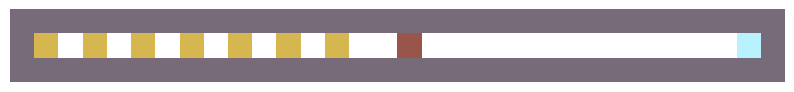

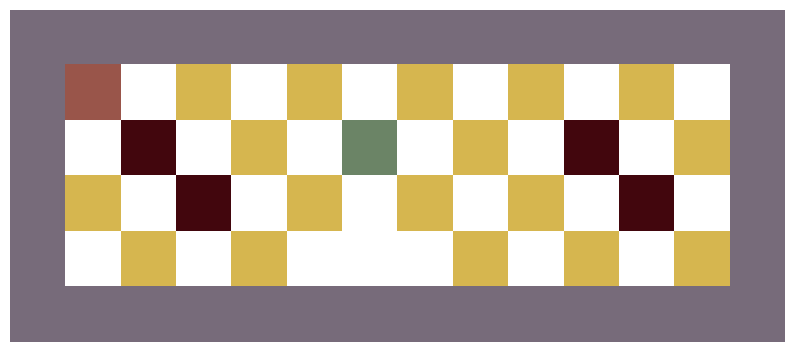

In [6]:
# Visualize the environment
plt.figure(figsize=(10, 10))

# T-Maze Environment
env_lin = gym.make("LinearTrack-v0")
_, obs_to_render = env_lin.reset_with_render()
env_lin.reset()
env_lin.render(obs_to_render)

plt.figure(figsize=(10, 10))
# Deadly Gridworld
env_grid = gym.make("DeadlyGrid-v0")
_, obs_to_render = env_grid.reset_with_render()
env_grid.reset()
env_grid.render(obs_to_render)

1300


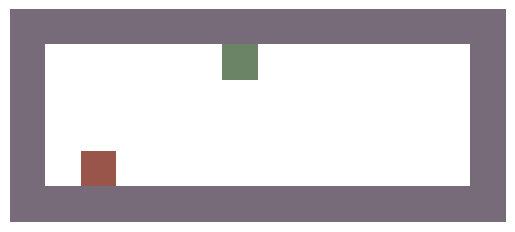

In [7]:
# Run random steps & Visualize the episode
from IPython import display

_, obs_to_render = env_grid.reset_with_render()
env_grid.render(obs_to_render)
rew_total = 0

i = 0
actions = [4] + [2 for i in range(11)]+[1]+[3 for i in range(11)]+[1]+[2 for i in range(11)]+[1]+[3 for i in range(11)]+[1]

while True:
    #action = env.action_space.sample()
    action = actions[i]
    i+=1
    _, rew , done, _, obs_to_render = env_grid.step_with_render(action)
    env_grid.render(obs_to_render)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    rew_total += rew
    if done:
        break
print(rew_total)

# Part 2 - Deep Q-Learning Agents

In [406]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_dim=384, output_dim=3):
        super(DQN, self).__init__()
        self.layer_in = nn.Linear(input_dim, 128)
        self.hidden_layer = nn.ReLU()
        self.layer_out = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = self.layer_in(x)
        x = self.hidden_layer(x)
        x = self.layer_out(x)
        return x

In [380]:
def to_torch(obs):
    return torch.tensor(obs, dtype=torch.float32).flatten() / 255.

In [446]:
class BaseTrainer:
    def __init__(self, grid_type = "linear", updates = 500, epochs = 1000, 
                 disc = 0.99, lr = 0.001, batch_size = 128, epsilon = 1):
        self.updates       = updates
        self.epochs        = epochs
        self.batch_size    = batch_size
        self.discount      = disc
        self.learning_rate = lr
        self.epsilon       = epsilon
        
        if grid_type == "linear":
            self.env   = gym.make("LinearTrack-v0")
        elif grid_type == "grid":
            self.env = gym.make("DeadlyGrid-v0")  
            
        self.obs   = self.env.reset()
        n,m,p      = np.shape(self.obs)
        self.model = DQN(n*m*p)
        
        self.loss_func = Loss(disc)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def epsilon_greedy(self, q_value):
        with torch.no_grad():
            if np.random.rand() < self.epsilon :
                action = torch.tensor(np.random.randint(q_value.shape[-1]))
            else:
                action = torch.argmax(q_value, dim=-1)
            return action

    def generate_episode(self):
        episode = []
        while True:
            action = self.epsilon_greedy(self.model(to_torch(self.obs)))
            next_obs, reward, done, _ = self.env.step(action)
            episode.append((self.obs, action, reward, next_obs))
            if done:
                break
            self.obs = next_obs
        return episode

    def compute_loss(self):
        states, actions, rewards, next_states = zip(*transitions)
        states = torch.stack(states)
        actions = torch.tensor(actions)
        rewards = torch.tensor(rewards)
        next_states = torch.stack(next_states)
        # Compute Q(s_t, a)
        state_action_values = self.model(to_torch(self.obs)).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        next_state_values = target_net(next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * gamma) + rewards
        loss = nn.MSELoss()(state_action_values, expected_state_action_values)
        return loss
    
    def optimize_model(policy_net, target_net, optimizer, transitions, gamma):
        loss = compute_loss(transitions, policy_net, target_net, gamma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


            
        

In [450]:
m = BaseTrainer()
m.generate_episode()

[(array([[[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]],
  
         [[0, 0, 0, 0],
          [0, 1, 0, 0],
          [0, 0, 0, 1],
          [0, 1, 0, 0],
          [0, 0, 0, 1],
          [0, 1, 0, 0],
          [0, 0, 0, 1],
          [0, 1, 0, 0],
          [0, 0, 0, 1],
          [0

In [158]:
class Loss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        self.loss = nn.MSELoss()
         
    def forward(self, q, action, double_q, target_q, 
                done, reward, weights):
        q_sampled_action = q.gather(-1, action.to(torch.long).unsqueeze(-1)).squeeze(-1)
        with torch.no_grad:
            best_next_action = torch.argmax(double_q, -1)
            best_next_q_value = target_q.gather(-1, best_next_action.unsqueeze(-1)).squeeze(-1)
            q_update = reward + self.gamma * best_next_q_value * (1 - done)
            td_error = q_sampled_action - q_update
        losses = self.loss(q_sampled_action, q_update)
        loss = torch.mean(weights * losses)
        return td_error, loss